# Customer Churn Prediction 💁‍♀️

## **Model Selection & Training**

In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score

## Data Preparation

In [2]:
# Load the data
ml_data = pd.read_csv('../Data/ml_data.csv')

In [3]:
# Data head
ml_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
0,7590-VHVEG,Female,0,1,0,0.013889,0,No phone service,No,Yes,...,0.115423,0.001275,0,False,False,False,True,False,False,False
1,5575-GNVDE,Male,0,0,0,0.472222,1,No,Yes,No,...,0.385075,0.215867,0,True,False,False,False,True,False,False
2,3668-QPYBK,Male,0,0,0,0.027778,1,No,Yes,Yes,...,0.354229,0.010310,1,False,False,False,False,True,False,False
3,7795-CFOCW,Male,0,0,0,0.625000,0,No phone service,Yes,No,...,0.239303,0.210241,0,True,False,False,False,False,False,False
4,9237-HQITU,Female,0,0,0,0.027778,1,No,No,No,...,0.521891,0.015330,1,False,False,False,True,False,True,False


In [4]:
# Data info
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7043 non-null   object 
 1   gender                                 7043 non-null   object 
 2   SeniorCitizen                          7043 non-null   int64  
 3   Partner                                7043 non-null   int64  
 4   Dependents                             7043 non-null   int64  
 5   tenure                                 7043 non-null   float64
 6   PhoneService                           7043 non-null   int64  
 7   MultipleLines                          7043 non-null   object 
 8   OnlineSecurity                         7043 non-null   object 
 9   OnlineBackup                           7043 non-null   object 
 10  DeviceProtection                       7043 non-null   object 
 11  Tech

In [5]:
# Define target (Churn) and features based on extensive EDA and data querying
y = ml_data['Churn']
X = ml_data.drop(columns = ['Churn', 'customerID', 'gender','MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                            'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling'])
X = X.replace({True: 1, False: 0})

C:\Users\isabe\AppData\Local\Temp\ipykernel_18212\3763113382.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({True: 1, False: 0})


In [6]:
# Define train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Modeling: Classification Problem

### Baseline Model

#### Logistic Regression

In [7]:
# Logistic Regression model training
model_lg = LogisticRegression()
model_lg.fit(X_train, y_train)

LogisticRegression()

In [8]:
# Logistic Regression model prediction
y_pred = model_lg.predict(X_test)

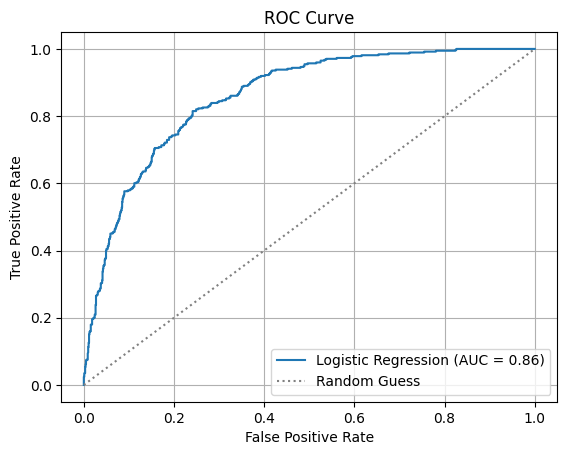

In [9]:
# Logistic Regression ROC Curve 
def roc_curve_plot(model, model_name):
    # ROC calculations
    proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})', linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='dotted', color='gray', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

roc_curve_plot(model_lg, 'Logistic Regression')

In [10]:
# Logistic Regression Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Predicted Not Churned', 'Predicted Churned'])
cm_df

,Predicted Not Churned,Predicted Churned
Not Churned,935,101
Churned,157,216


In [11]:
# Logistic Regression Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.rename(index={'0': 'Not Churned', '1': 'Churned'}, inplace=True)
report_df = report_df.round(2)
report_df

,precision,recall,f1-score,support
Not Churned,0.86,0.90,0.88,1036.00
Churned,0.68,0.58,0.63,373.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.77,0.74,0.75,1409.00
weighted avg,0.81,0.82,0.81,1409.00


In the scenario of predicting churned customers, a false negative (missing a churned customer) is more expensive than a false positive (identifying as churned a customer who does not churn). This is normally the case because bringing back a lost customer requires significant resources in the form of marketing, discounts, and offers. Therefore, the churn prediction model is most valuable when it maximises recall for churn and the ROC AUC (particularly useful in this case as there is an imbalance between churned and not churned classes).

### Advanced Models

#### Random Forest

In [12]:
# Random Forest model training
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Random Forest model prediction
y_pred_rf = model_rf.predict(X_test)

#### XGBoost

In [13]:
# XGB model training
model_xgb = xgb.XGBClassifier(eval_metric='mlogloss')
model_xgb.fit(X_train, y_train)

#XGB model prediction
y_pred_xgb = model_xgb.predict(X_test)

#### Neural Networks

In [14]:
# Neural Networks model training
model_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=1)
model_nn.fit(X_train, y_train)

# Neural Networks model prediction
y_pred_nn = model_nn.predict(X_test)

#### ROC Curve Comparison

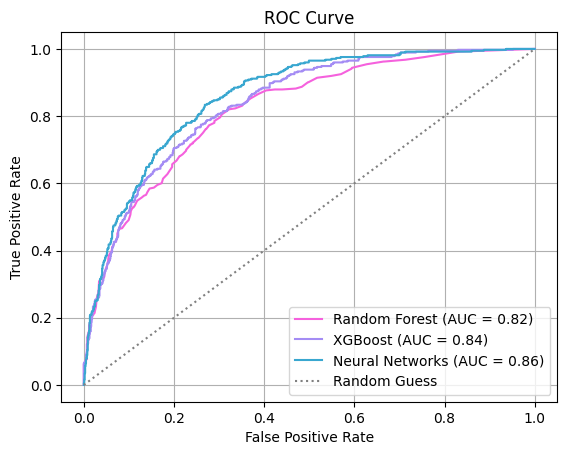

In [15]:
# Random Forest
proba_rf = model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
auc_rf = roc_auc_score(y_test, proba_rf)

# XGBoost
proba_xgb = model_xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, proba_xgb)
auc_xgb = roc_auc_score(y_test, proba_xgb)

# Neural Networks
proba_nn = model_nn.predict_proba(X_test)[:,1]
fpr_nn, tpr_nn, _ = roc_curve(y_test, proba_nn)
auc_nn = roc_auc_score(y_test, proba_nn)

# Format Plot
palette = sns.color_palette("husl", 8)
plt.plot(fpr_rf, tpr_rf, color=palette[7], label=f'Random Forest (AUC = {auc_rf:.2f})', linestyle='-')
plt.plot(fpr_xgb, tpr_xgb, color=palette[6], label=f'XGBoost (AUC = {auc_xgb:.2f})', linestyle='-')
plt.plot(fpr_nn, tpr_nn, color=palette[5], label=f'Neural Networks (AUC = {auc_nn:.2f})', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='dotted', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


#### Recall Comparison

In [16]:
# Random Foresr Recall
recall_rf = recall_score(y_test, y_pred_rf)

# XGBoost Recall
recall_xgb = recall_score(y_test, y_pred_xgb)

# Neural Networks Recall
recall_nn = recall_score(y_test, y_pred_nn)

# Print Recall
df_recall = pd.DataFrame({'Recall': [recall_rf, recall_xgb, recall_nn]}, index=['Random Forest', 'XGBoost', 'Neural Networks'])
df_recall = df_recall.round(2)
df_recall

,Recall
Random Forest,0.52
XGBoost,0.52
Neural Networks,0.61


### Hyperparameter Fine Tuning

#### Logistic Regression

**Randomised Grid Search & Cross Validation**

In [17]:
# Parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag'],
    'max_iter': [100, 200, 300],
    'penalty': ['l2', 'l1'],
    'class_weight': [None, 'balanced']
}

# Randomized Search
random_search = RandomizedSearchCV(estimator=model_lg, param_distributions=param_grid, n_iter=100, cv=5, scoring='recall')
random_search.fit(X_train, y_train)
random_search.best_params_

c:\Users\isabe\Desktop\Churn Prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\isabe\Desktop\Churn Prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\isabe\Desktop\Churn Prediction\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\isabe\Desktop\Churn Prediction\.venv\

{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 200,
 'class_weight': 'balanced',
 'C': 10}

**Model Update**

In [18]:
# Best Logistic Regression model
model_lg_best = random_search.best_estimator_
y_pred_lg_best = model_lg_best.predict(X_test)


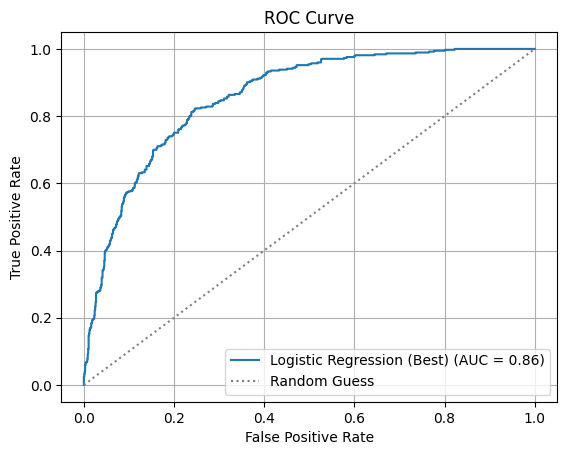

In [19]:
# Best Logistic Regression model ROC Curve
roc_curve_plot(model_lg_best, 'Logistic Regression (Best)')

In [20]:
# Best Logistic Regression Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lg_best)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Predicted Not Churned', 'Predicted Churned'])
cm_df

,Predicted Not Churned,Predicted Churned
Not Churned,738,298
Churned,61,312


In [21]:
# Best Logistic Regression Classification Report
report = classification_report(y_test, y_pred_lg_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.rename(index={'0': 'Not Churned', '1': 'Churned'}, inplace=True)
report_df = report_df.round(2)
report_df

,precision,recall,f1-score,support
Not Churned,0.92,0.71,0.80,1036.00
Churned,0.51,0.84,0.63,373.00
accuracy,0.75,0.75,0.75,0.75
macro avg,0.72,0.77,0.72,1409.00
weighted avg,0.81,0.75,0.76,1409.00


**SHAP Analysis**

In [22]:
# Initialize SHAP explainer
explainer = shap.Explainer(model_lg_best, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

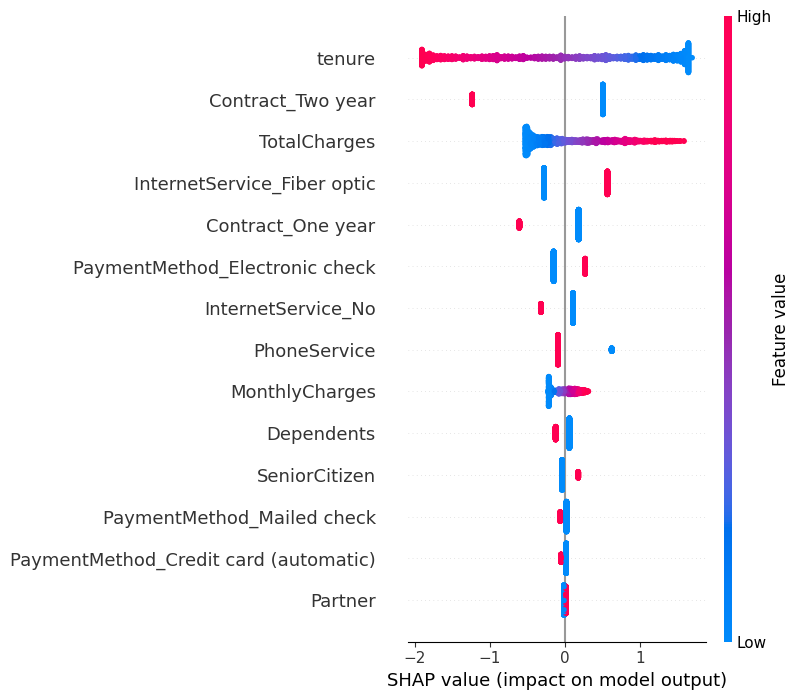

In [23]:
shap.summary_plot(shap_values, X_test)

#### Neural Networks (MLP Classifier)

**Randomised Grid Search & Cross Validation**

In [31]:
# Parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01],  # Regularization term
    'batch_size': ['auto', 32, 64],
    'max_iter': [100, 200, 300]
}

# Randomized Search
random_search = RandomizedSearchCV(estimator=model_nn, param_distributions=param_grid, n_iter=10, cv=3, scoring= 'recall', random_state=1)
random_search.fit(X_train, y_train)
random_search.best_params_

c:\Users\isabe\Desktop\Churn Prediction\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\isabe\Desktop\Churn Prediction\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\isabe\Desktop\Churn Prediction\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\isabe\Desktop\Churn Prediction\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  war

{'solver': 'sgd',
 'max_iter': 100,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (50, 50),
 'batch_size': 32,
 'alpha': 0.01,
 'activation': 'relu'}

**Model Update**

In [32]:
# Best MLPClassifier model
model_nn_best = random_search.best_estimator_
y_pred_nn_best = model_nn_best.predict(X_test)

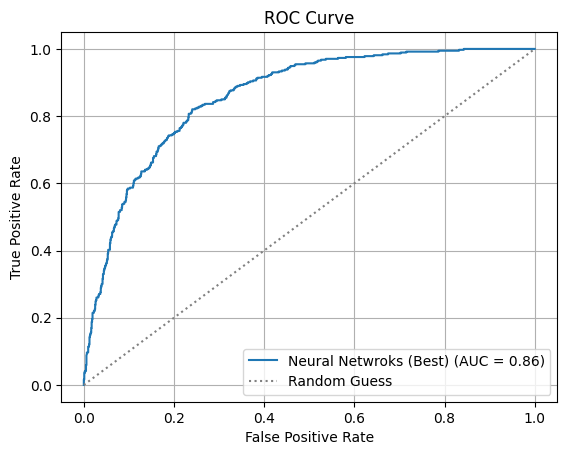

In [33]:
# Best MLPClassifier model ROC Curve
roc_curve_plot(model_nn_best, 'Neural Netwroks (Best)')

In [34]:
# Best MLPClassifier Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn_best)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Predicted Not Churned', 'Predicted Churned'])
cm_df

,Predicted Not Churned,Predicted Churned
Not Churned,939,97
Churned,168,205


In [35]:
# Best MLPCLassifier Classification Report
report = classification_report(y_test, y_pred_nn_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.rename(index={'0': 'Not Churned', '1': 'Churned'}, inplace=True)
report_df = report_df.round(2)
report_df

,precision,recall,f1-score,support
Not Churned,0.85,0.91,0.88,1036.00
Churned,0.68,0.55,0.61,373.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.76,0.73,0.74,1409.00
weighted avg,0.80,0.81,0.81,1409.00


## Conclusion

In this analysis, the baseline model, Logistic Regression, demonstrated strong performance with an AUC of 0.86 and a churn recall of 0.58. Advanced models, including Random Forest, XGBoost, and Neural Networks, were also evaluated. While these models achieved similar AUC scores (0.82, 0.84, and 0.86 respectively), the churn recall was comparatively lower for Random Forest and XGBoost (0.52 for both), and marginally higher for Neural Networks (0.61). After hyperparameter tuning, the Logistic Regression model showed a significant improvement in recall (0.84), outperforming the Neural Networks model (0.55). As a result, the Logistic Regression model was selected as the best model for churn prediction in this scenario.

The SHAP analysis on the Logistic Regression model provided insightful explanations, confirming the findings from the exploratory data analysis (EDA) and querying phases. The key drivers of churn are tenure (shorter tenure increases the likelihood of churn), contract type (month-to-month contracts are associated with higher churn), and total charges (higher charges correlate with a higher likelihood of churn).

## Future Work

Future work could explore the following avenues:

- Model Refinement: Further experiments with more complex models, such as ensemble methods (stacking, bagging, boosting), could improve prediction accuracy.
- Feature Engineering: Additional feature engineering or incorporating external data sources (e.g., customer service interactions) could provide new insights and improve model performance.
- Model Interpretability: While SHAP provided valuable insights, integrating other explainability techniques such as LIME could enhance the understanding of model predictions, at individual level.
- Deployment: Moving towards model deployment in a real-time production environment and assessing its performance in a live setting.
- Churn Mitigation: Leveraging the model to identify at-risk customers and integrating it into churn prevention strategies.

This work lays a solid foundation for improving churn prediction and providing actionable insights for customer retention strategies.